# GANS/Cyclic GANS For Data Augmentation and Neural Style Transfer

In [1]:
import tensorflow as tf
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import random
import itertools
import math
import time

from skimage.io import imread
from skimage.transform import resize

# Model class
from tensorflow.keras.models import Model

# Layers
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dropout, Flatten, Conv2D, Dense, MaxPool2D, Conv2DTranspose, GlobalMaxPool2D, Reshape, BatchNormalization, Input
from tensorflow.keras.layers import Layer

# Optimizer
from tensorflow.keras.optimizers import Adam

# Loss function
from tensorflow.keras.losses import BinaryCrossentropy

# Data loader
from tensorflow.keras.utils import Sequence

# Metrics
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision, MSE

# ImageLoader
from skimage.io import imread

# Weights Initializer
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, GlorotUniform

# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

## Getting The Data

In [2]:
def split_data(data_dir, split):
    
    dirs = split.keys()
    # get existing folders names 
    subdirs = [x for x in os.listdir(data_dir) if x not in dirs]
    
    # filling dataset structure
    dataset_dir_structure = {}
    
    for dir_ in dirs:
        dataset_dir_structure[dir_] = subdirs
        
    for key, val in dataset_dir_structure.items():
        if isinstance(val, list):
            for sub_key in val:
                Path(Path(data_dir) / key /
                     sub_key).mkdir(exist_ok=True, parents=True)
    
    cat_images = glob.glob(f"{data_dir}/Cat/*.jpg")
    dog_images = glob.glob(f"{data_dir}/Dog/*.jpg")
    
    assert sum(list(split.values())) < (len(cat_images)+len(dog_images)), f"Split values should not excceed number of datapoints: {sum(list(split.values()))} > {(len(cat_images)+len(dog_images))}"
    
    for split_dir in split.keys():
        for i in range(int(split[split_dir]/2)):
            cat_im = np.random.choice(cat_images)
            shutil.copy(cat_im, f"{data_dir}/{split_dir}/Cat/{i}.jpg")
            cat_images.remove(cat_im)
        
            dog_im = np.random.choice(dog_images)
            shutil.copy(dog_im, f"{data_dir}/{split_dir}/Dog/{i}.jpg")
            dog_images.remove(dog_im)

In [3]:
split_data("PetImages", {"train": 2500, "test": 500})

FileNotFoundError: [Errno 2] No such file or directory: 'PetImages'

## Pre-Processing The Data

In [2]:
# create a dataloader iterator that loads data from directory
# batch data
# resize to all the same size
# split train test
# normalize (min-max)

In [3]:
class DataLoader(Sequence):
    
    def __init__(self, im_dir, labels= None, batch_size= 32, resize= False, output_dim= None, classification= True, shuffle= True):
        
        self.im_dir = im_dir
        self.classification = classification
        self.shuffle = shuffle
        self.resize = resize
        self.output_dim = output_dim
        self.batch_size = batch_size
        
        self.labels = {}
        if isinstance(labels, list):
            for i, label in enumerate(labels):
                self.labels[label] = i
        elif isinstance(labels, dict):
            self.labels = labels
        else:
            for root_dir, subdirs, files in os.walk(self.im_dir):
                for i, subdir in enumerate(subdirs):
                    self.labels[subdir] = i
        
            
        self.images = glob.glob(f"{self.im_dir}/*/*")
        random.shuffle(self.images)
        
        self.on_epoch_end()
        
    
    def __len__(self):
        return int(np.floor(len(self.images)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        im_files_batch = [self.images[idx] for idx in indexes]
        if self.resize:
            batch_images = np.array([resize(imread(file), self.output_dim, preserve_range= True) for file in im_files_batch], dtype= np.uint8)
            #batch_images = (np.asanyarray(batch_images, dtype= np.float32) - 127.5)/127.5
            batch_images = np.asanyarray(batch_images, dtype= np.float32)/255.
            
        else:
            batch_images = np.arrary([imread(file) for file in im_files_batch], dtype= np.uint8)
        
        batch_labels = np.empty((self.batch_size), dtype= np.int8)
        for i, im in enumerate(im_files_batch):
            for label in self.labels.keys():
                if label in im:
                    batch_labels[i] = self.labels[label]
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        "Updates all indexes after the end of each epoch"
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
        
    def add_data(self, batched_data):
        return

In [4]:
train_cat_dog_data = DataLoader(im_dir= "dataset/Newdata/Train", resize= True, output_dim= (200, 200, 3))
val_cat_dog_data = DataLoader(im_dir= "dataset/Newdata/Test", resize= True, output_dim= (200, 200, 3))

Show a bit more of the data

## Define Metrics For Classification
- Accuracy
- Precision
- Recall

In [5]:
def show_metrics_classification(model_history):
    metrics = ["_".join(metric.split("_")[1:]) for metric in model_history.history.keys() if "val" not in metric]
    print(metrics)
    colors = list(itertools.combinations(['b', 'g', 'r', 'c', 'm', 'y', 'k'], 2))
    
    f = plt.figure()
    f.set_figwidth(2.5*len(metrics))
    f.set_figheight(3*len(metrics))
    for i, metric in enumerate(metrics):
        plt.subplot(math.ceil(len(metrics)/2), 2, i+1)
        color_plts = np.random.randint(0, len(colors))
        plt.plot(model_history.history[f"train_{metric}"], color= colors[color_plts][0])
        plt.plot(model_history.history[f"val_{metric}"], color= colors[color_plts][1])
        plt.ylabel(metric)
        plt.xlabel("epochs")
        plt.legend(["train", "val"], loc= "upper left")
        plt.title(f"{metric.title()} vs Epochs")
    plt.show()
    

## Building The Classifier

In [6]:
class Classifier(Model):
    
    def __init__(self, name):
        super(Classifier, self).__init__(name= name)
        
    def build(self, input_shape):
        
        self.conv1 = Conv2D(filters= 50, kernel_size= 3, activation= 'relu', padding= 'same', kernel_initializer= 'glorot_uniform', input_shape= input_shape)
        self.maxpool1 = MaxPool2D(pool_size= (2, 2))
        
        self.conv2 = Conv2D(filters= 20, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool2 = MaxPool2D(pool_size= (2, 2))
        
        self.conv3 = Conv2D(filters= 5, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool3 = MaxPool2D(pool_size= (2, 2))
        
        self.flatten = Flatten()
        self.dense1 = Dense(units= 30, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense2 = Dense(units= 20, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense3 = Dense(units= 1, activation= 'sigmoid', kernel_initializer= 'glorot_uniform')
        
        super(Classifier, self).build(input_shape)
    
    def call(self, input_):
        x = self.conv1(input_)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.maxpool3(x)
     
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        output = self.dense3(x)
        return output
    
    def train_step(self, train_batch):
        X_train, y_train = train_batch
        
        with tf.GradientTape() as tape:
            # apply forward pass
            y_pred = self(X_train, training= True)
            loss = self.compiled_loss(y_train, y_pred, regularization_losses= self.losses)
        # calculate gradients - uses reverse gradient autodiff
        gradients = tape.gradient(loss, self.trainable_variables)
        # backpropagate the gradients and update the weights using the compiled optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.compiled_metrics.update_state(y_train, y_pred)
        return {f"train_{metric.name}": metric.result() for metric in self.metrics}
    
    def test_step(self, test_batch):
        X_test, y_test = test_batch
        # obtain prediciton
        y_pred = self(X_test, training= False)
        
        # updates loss metric
        self.compiled_loss(y_test, y_pred)
        
        # updates metrics
        self.compiled_metrics.update_state(y_test, y_pred)
        
        return {f"{metric.name}": metric.result() for metric in self.metrics}

## Traning the Classifier

In [7]:
tf.keras.backend.clear_session()
with tf.device('/device:GPU:0'):
    
    cats_dogs_classifier = Classifier(name= "cvd")
    cats_dogs_classifier.build(input_shape= (None, 200, 200, 3))

    cats_dogs_classifier.summary()
    cats_dogs_classifier.compile(optimizer= Adam(0.001), loss= BinaryCrossentropy(), metrics= [BinaryAccuracy(), Recall(), Precision(), MSE])
    model_data = cats_dogs_classifier.fit(train_cat_dog_data, validation_data= val_cat_dog_data, epochs= 50, workers= 10)

Model: "cvd"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9020      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  905       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0       

Epoch 21/50
2/2 [==============================] - 1s 386ms/step - train_loss: 0.0132 - train_binary_accuracy: 1.0000 - train_recall: 1.0000 - train_precision: 1.0000 - train_mean_squared_error: 0.0029 - val_loss: 3.4974 - val_binary_accuracy: 0.5312 - val_recall: 0.1875 - val_precision: 0.6000 - val_mean_squared_error: 0.4352
Epoch 22/50
2/2 [==============================] - 1s 387ms/step - train_loss: 6.4955e-04 - train_binary_accuracy: 1.0000 - train_recall: 1.0000 - train_precision: 1.0000 - train_mean_squared_error: 5.5708e-06 - val_loss: 4.0469 - val_binary_accuracy: 0.5312 - val_recall: 0.0323 - val_precision: 1.0000 - val_mean_squared_error: 0.4404
Epoch 23/50
2/2 [==============================] - 1s 389ms/step - train_loss: 3.9347e-04 - train_binary_accuracy: 1.0000 - train_recall: 1.0000 - train_precision: 1.0000 - train_mean_squared_error: 1.4897e-06 - val_loss: 4.2868 - val_binary_accuracy: 0.4844 - val_recall: 0.0323 - val_precision: 0.2500 - val_mean_squared_error: 0.47

['loss', 'binary_accuracy', 'recall', 'precision', 'mean_squared_error']


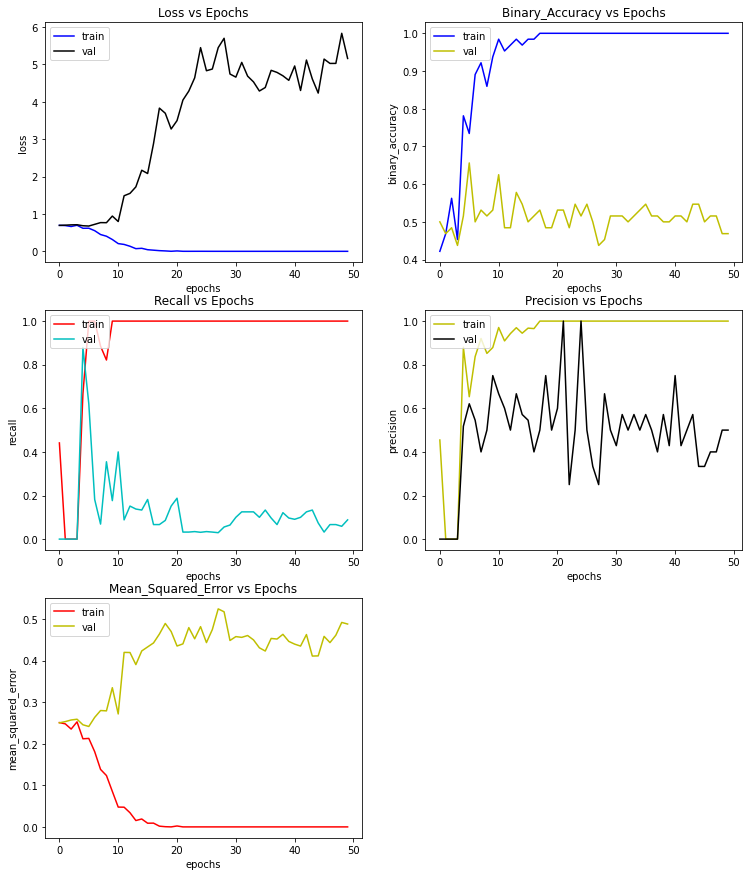

In [9]:
show_metrics_classification(cats_dogs_classifier.history)

## DC-GAN

**Callbacks**

In [10]:
class SaveImagesCallback(Callback):
    def __init__(self, logdir, latent_dim, save_freq):
        self.logdir = Path(f"{logdir}/gan_image_output/{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
        self.latent_dim = latent_dim
        self.save_freq = save_freq
        
        self.logdir.mkdir(exist_ok=True, parents=True)
        self.fixed_noise = tf.random.normal([batch_size, 1, 1, self.latent_dim])
        
    def on_epoch_end(self, epoch, logs= None):
        if epoch % self.save_freq == 0:
            generator = self.model.generator
            predictions = generator(self.fixed_noise, training=False)
            
            pred_index = np.random.choice(np.array(list(range(predictions.shape[0]))), size= predictions.shape[0])
            predictions = np.array([predictions[x, :, :, :] for x in pred_index])

            plt_shape = int(np.math.sqrt(predictions.shape[0]))
            
            fig = plt.figure(figsize=(8, 8))
            for i in range(predictions.shape[0]):
                plt.subplot(plt_shape, plt_shape, i+1)
                plt.imshow(np.asarray(predictions[i, :, :, :] * 127.5 + 127.5, dtype= np.uint8))
                plt.axis('off')

            plt.savefig(f'{str(self.logdir)}/tf_image_at_epoch_{epoch:04d}.png')
            
            img_array = imread(f'{str(self.logdir)}/tf_image_at_epoch_{epoch:04d}.png')
            #images = wandb.Image(img_array, caption= "Generated Images")
            #wandb.log({"generated_images_example": images})

### Building The GAN Architecture
#### Generator

In [11]:
import tensorflow.keras as keras
from tensorflow.keras import layers

class Conv2DTBatchNorm(Layer):
    def __init__(self, filters, kernel_size, strides, padding, use_bias):
        super(Conv2DTBatchNorm, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
    
    def build(self, input_shape):
        self.conv2d_t = Conv2DTranspose(filters= self.filters, kernel_size= self.kernel_size, strides= self.strides, use_bias= self.use_bias)
        self.batch_norm = BatchNormalization()
        self.leaky_relu = LeakyReLU()
        super(Conv2DTBatchNorm, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        
        x = self.conv2d_t(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        
        return x    

In [111]:
class Generator(Model):
    def __init__(self, latent_dim, name, **kwargs):
        super(Generator, self).__init__(name= name, **kwargs)
        self.latent_dim = latent_dim
    
    def build(self, input_shape):
        assert input_shape[1:] == (1, 1, self.latent_dim), f"input_shape should have shape (batch_size, 1, 1, latent_dimension), received: {input_shape}"
        self.conv2d_t_1 = Conv2DTBatchNorm(filters= 64*12, kernel_size= (4, 4), strides=(1, 1), padding="valid", use_bias= False)
        self.conv2d_t_2 = Conv2DTBatchNorm(filters= 64*8, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_3 = Conv2DTBatchNorm(filters= 64*8, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_4 = Conv2DTBatchNorm(filters= 64*4, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_5 = Conv2DTBatchNorm(filters= 64*4, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_6 = Conv2DTBatchNorm(filters= 64*2, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        
        self.conv2d = Conv2D(filters= 3, kernel_size= (3, 3), strides=(1, 1), padding="same", use_bias= False, activation= "tanh")
        super(Generator, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv2d_t_1(x)
        x = self.conv2d_t_2(x)
        x = self.conv2d_t_3(x)
        x = self.conv2d_t_4(x)
        x = self.conv2d_t_5(x)
        x = self.conv2d_t_6(x)
        
        x = self.conv2d(x)
        return x

#### Discriminator

In [117]:
class Conv2DBatchNorm(Layer):
    def __init__(self, filters, kernel_size, strides, padding, use_bias, batch_norm= True):
        super(Conv2DBatchNorm, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.batch_norm = batch_norm
        
    def build(self, input_shape):
        self.conv = Conv2D(filters= self.filters, kernel_size= self.kernel_size, strides= self.strides, padding= self.padding, use_bias= self.use_bias)
        if self.batch_norm:
            self.bn = BatchNormalization()
        self.leaky_relu = LeakyReLU(alpha= 0.2)
        
        super(Conv2DBatchNorm, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.leaky_relu(x)
        
        return x

In [118]:
class Discriminator(Model):
    def __init__(self, name, **kwargs):
        super(Discriminator, self).__init__(name, **kwargs)
    
    def build(self, input_shape):
        self.conv1 = Conv2DBatchNorm(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        
        self.conv_bn_1 = Conv2DBatchNorm(filters=64*2, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        self.conv_bn_2 = Conv2DBatchNorm(filters=64*4, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_3 = Conv2DBatchNorm(filters=64*8, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_4 = Conv2DBatchNorm(filters=64*8, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_5 = Conv2DBatchNorm(filters=64*4, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_6 = Conv2DBatchNorm(filters=64*2, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        self.conv_bn_7 = Conv2DBatchNorm(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)  
        
        self.conv2 = Conv2D(1, (3, 3), strides=(4, 4), padding="same", use_bias= False, activation= 'sigmoid')
        super(Discriminator, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv1(x)
        
        x = self.conv_bn_1(x)
        x = self.conv_bn_2(x)
        x = self.conv_bn_3(x)
        x = self.conv_bn_4(x)
        x = self.conv_bn_5(x)        
        x = self.conv_bn_6(x)
        x = self.conv_bn_7(x)
        
        x = self.conv2(x)
        return x

#### GAN

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, batch_size):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def call(self, data, training=False): 
        # Method needed to be implemented for tensorflow reasons when using a custom data loader
        pass
    
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = self.batch_size
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))
        
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1, 1, 1)), tf.zeros((batch_size, 1, 1, 1))], axis=0
        )
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1, 1, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 16
EPOCHS= 30000
EPOCH_SAVE_FREQ = 30000

IMAGE_SIZE = (128, 128, 3)
train_cat_dog_data = DataLoader(im_dir= "dataset/Newdata/train_merged", resize= True, output_dim= IMAGE_SIZE, batch_size= batch_size)

data_len = len(train_cat_dog_data)

logdir = 'gan-logdir/horses_cows/'
isaveimg = SaveImagesCallback(logdir= logdir, latent_dim= latent_dim, save_freq= 100)
model_checkpoint = ModelCheckpoint(
                    filepath= f"{logdir}/model_checkpoint/{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
                    monitor= "g_loss",
                    save_freq= data_len*EPOCH_SAVE_FREQ)

with tf.device('/device:GPU:0'):
    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, batch_size= batch_size)
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
    
    optimizer_d = keras.optimizers.Adam(learning_rate=lr_schedule)
    optimizer_g = keras.optimizers.Adam(learning_rate= lr_schedule)

    wandb.config = {
        "learning_rate": lr_schedule,
        "epochs": EPOCHS,
        "batch_size": batch_size,
        "latent_dim": latent_dim,
        "image_size": IMAGE_SIZE
    }

    gan.compile(
        #d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        #g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        d_optimizer= optimizer_d,
        g_optimizer= optimizer_g,
        loss_fn=keras.losses.BinaryCrossentropy(),
    )

    # To limit the execution time, we only train on 100 batches. You can train on
    # the entire dataset. You will need about 20 epochs to get nice results.
    gan.fit(train_cat_dog_data, epochs=EPOCHS, callbacks= [isaveimg, WandbCallback()], workers= 16)

In [8]:
class GAN(Model):
    def __init__(self, discriminator: Discriminator, generator: Generator, name):
        super(GAN, self).__init__(name= name)
        self.discriminator = discriminator
        self.generator = generator
    
    def compile(self, g_opt, disc_opt, loss_fun, run_eagerly= False):
        super(GAN, self).compile(run_eagerly= run_eagerly)
        self.g_opt = g_opt
        self.disc_opt = disc_opt
        self.loss_fn = loss_fun
    
    def call(self, data, training= False):
        # method for tensorflow to run properly in graph mode
        pass
    
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space

        batch_size = real_images.shape[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        # Add random noise to the labels - important trick!
        #labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        # Train the discriminator
        with tf.GradientTape() as tape:
            
            predictions = self.discriminator(combined_images)
            
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.disc_opt.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))
        
        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_opt.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [9]:
generator = Generator(name= "Generator")
discriminator = Discriminator(name= "Discriminator")
gan = GAN(discriminator, generator,name= "gan")

In [13]:
gan.compile(Adam(learning_rate= 0.01), Adam(learning_rate= 0.01), BinaryCrossentropy())
hist = gan.fit(train_cat_dog_data, epochs= 3, workers= 10)

NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.

### Next Steps
We experimented with normal GANs and we were able to see good results for generating horse and cow data. The next steps are the following:
- [ ] Research Conditional GANs or cGANs
- [ ] Research bidirectional and Cyclic GANs
- [ ] Implement cGAN for Data Augmentation
- [ ] Benchmark on horse vs cows, if possible cats vs dogs classification 
- [ ] Initiate Paper and repo clean build